##### Import Libraries

In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import pathlib
from keras.utils import plot_model
from keras import Sequential

import glob
import imageio

#####  Import Data 

In [33]:
T1 = r'C:\Users\nikhi\Downloads\Style Transfer using GAN\Tr1'

T2 = r'C:\Users\nikhi\Downloads\Style Transfer using GAN\Tr2'

In [34]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)                                                  

In [35]:
t1_generator = train_datagen.flow_from_directory(T1, color_mode='grayscale', target_size=(128,128),
                                                     class_mode='sparse' ,batch_size=64,
                                                    shuffle=True,seed=42
                                                    )



Found 43 images belonging to 1 classes.


In [36]:
t2_generator = train_datagen.flow_from_directory(T2, color_mode='grayscale',target_size=(128,128),
                                                    class_mode='sparse' ,batch_size=64,
                                                    shuffle=True,seed=42
                                                    )

Found 46 images belonging to 1 classes.


In [ ]:
t1_generator[0][0].shape[0]

In [37]:
batch_size=16

In [38]:
data_T1 = tf.data.Dataset.from_tensor_slices(t1_generator[0][0]).shuffle(t1_generator[0][0].shape[0],seed=43).batch(batch_size)

data_T2 = tf.data.Dataset.from_tensor_slices(t2_generator[0][0]).shuffle(t1_generator[0][0].shape[0],seed=43).batch(batch_size)

In [39]:
print(type(data_T1))
print(type(data_T2))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


#### Data Visualization 

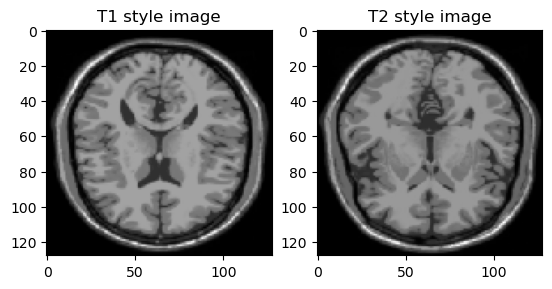

In [40]:
example_T1 = next(iter(data_T1))

example_T2 = next(iter(data_T2))

imgs = [example_T1[0], example_T2[0]]

for img in range(len(imgs)):
    plt.subplot(1,2,img+1)
    
    plt.imshow(example_T1[img], cmap='gray')
    
    if(img==0):
        plt.title('T1 style image')
    else:
        plt.title('T2 style image')

plt.show()

### Model Building 

In [41]:
# Instance Normalization

class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [42]:
# Downsampling Function

def downsample(filters, f_size, apply_norm=True):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    ds_model = tf.keras.Sequential()
    
    ds_model.add(tf.keras.layers.Conv2D(filters, (f_size, f_size), strides=(2,2), padding='same',
                                        kernel_initializer=initializer, use_bias=False))
    
    if(apply_norm):
        ds_model.add(InstanceNormalization())
    
    ds_model.add(tf.keras.layers.ReLU())
    
    return ds_model

In [43]:
# Upsampling Function

def upsample(filters, f_size, apply_dropout=True):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    us_model = tf.keras.Sequential()
    
    us_model.add(tf.keras.layers.Conv2DTranspose(filters, (f_size,f_size), strides=(2,2), padding='same',
                                                 kernel_initializer=initializer, use_bias=False))
    
    if(apply_dropout):
        us_model.add(tf.keras.layers.Dropout(0.5))
        
    us_model.add(tf.keras.layers.ReLU())
    
    return us_model


In [44]:
# U-net generator

def unet_generator():
    
    down_stack=[
        downsample(32, 4, False), #(64,64,32)
        downsample(64,4),         #(32,32,64)
        downsample(128,4),        #(16,16,128)
        downsample(128,4),         #(8,8,128)
        downsample(128,4),       #(4,4,128)
        downsample(128,4),       #(2,2,128)
        downsample(128,4)        #(1,1,128)
        
    ]
    
    up_stack = [
        upsample(128, 4, True), # (bs, 2, 2, 256)
        upsample(128, 4, True), # (bs, 4, 4, 256)
        upsample(128, 4), # (bs, 8, 8, 256)
        upsample(128, 4), # (bs, 16, 16, 128)
        upsample(128, 4),
        upsample(64, 4)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same',
                                           kernel_initializer=initializer,activation='tanh') # (bs, 32, 32, 1)
    
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [45]:
generator_g = unet_generator()

generator_f = unet_generator()

In [46]:
generator_g.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_30 (Sequential)     (None, 64, 64, 32)   512         ['input_3[0][0]']                
                                                                                                  
 sequential_31 (Sequential)     (None, 32, 32, 64)   32896       ['sequential_30[0][0]']          
                                                                                                  
 sequential_32 (Sequential)     (None, 16, 16, 128)  131328      ['sequential_31[0][0]']    

In [47]:
# Discriminator function

def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    x = inp

    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64) (64,64,64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)  (32,32,128)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 10, 10, 128) (34,34,128)

    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(256, 4, strides=1,use_bias=False)(zero_pad1) # (bs, 7, 7, 256) ()
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)

    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)


In [48]:
discriminator_t1 = discriminator()

discriminator_t2 = discriminator()

In [49]:
discriminator_t1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 sequential_56 (Sequential)  (None, 64, 64, 64)        1024      
                                                                 
 sequential_57 (Sequential)  (None, 32, 32, 128)       131328    
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 34, 34, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 31, 31, 256)       524288    
                                                                 
 instance_normalization_29 (  (None, 31, 31, 256)      512       
 InstanceNormalization)                                    

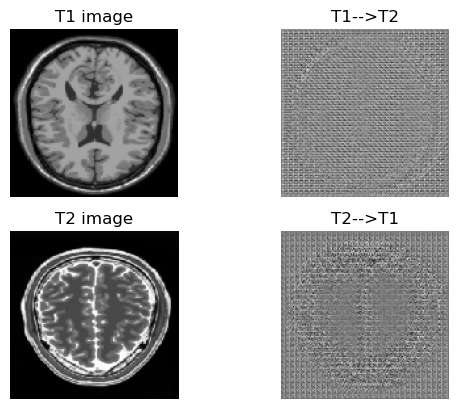

In [50]:
# We haven't trained the model yet. Just plotted down the images from Generators to get an idea of what they'd print.

to_T2 = generator_g(example_T1)

to_T1 = generator_f(example_T2)

img_list = [example_T1,to_T2, example_T2, to_T1]

titles=['T1 image', 'T1-->T2','T2 image', 'T2-->T1']

i=1
for img,title in zip(img_list,titles):
    plt.subplot(2,2,i)
    plt.imshow(img[0], cmap='gray')
    plt.title(title)
    plt.axis('off')
    i+=1
plt.show()

#### Loss Declaration 

In [51]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [52]:
# Discriminator loss on real and generated image

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

In [53]:
# Generator loss on generated images

def generator_loss(generated):
    return loss_obj(tf.zeros_like(generated),generated)
     

In [54]:
def cycle_loss(real,cycled):
    c_loss = tf.reduce_mean(tf.abs(real-cycled))
    return c_loss*10.0

In [55]:
def identity_loss(real,same_img):
    i_loss = tf.reduce_mean(tf.abs(real-same_img))
    return i_loss*0.1

#### Optimizers 

In [56]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_t1_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_t2_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Checkpoint Initialization 

In [57]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_t1=discriminator_t1,
                           discriminator_t2=discriminator_t2,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_t1_optimizer=discriminator_t1_optimizer,
                           discriminator_t2_optimizer=discriminator_t2_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [58]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [59]:
def train_start(real_t1, real_t2):
    
    with tf.GradientTape(persistent=True) as tape:
        
        generated_t2 = generator_g(real_t1, training=True)
        cycled_t1 = generator_f(generated_t2, training=True)
        
        generated_t1 = generator_f(real_t2, training=True)
        cycled_t2 = generator_g(generated_t1, training=True)
        
        same_t1 = generator_f(real_t1, training=True)
        same_t2 = generator_g(real_t2, training=True)
        
        disc_real_t1 = discriminator_t1(real_t1, training=True)
        disc_real_t2 = discriminator_t2(real_t2, training=True)
        
        disc_gen_t1 = discriminator_t1(generated_t1, training=True)
        disc_gen_t2 = discriminator_t2(generated_t2, training=True)
        
        # Generator loss calculation
        generator_g_loss = generator_loss(disc_gen_t2)
        generator_f_loss = generator_loss(disc_gen_t1)
        
        # Total Generator Loss
        total_gen_g_loss = generator_g_loss + cycle_loss(real_t2,cycled_t2) + identity_loss(real_t2,same_t2)
        total_gen_f_loss = generator_f_loss + cycle_loss(real_t1,cycled_t1) + identity_loss(real_t1,same_t1)
        
        # Discriminator Loss
        disc_t1_loss = discriminator_loss(disc_real_t1, disc_gen_t1)
        disc_t2_loss = discriminator_loss(disc_real_t2, disc_gen_t2)
        
        #Calculate gradients for Gen_g and Gen_f
        gen_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
        gen_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
        
        disc_t1_gradients = tape.gradient(disc_t1_loss, discriminator_t1.trainable_variables)
        disc_t2_gradients = tape.gradient(disc_t2_loss, discriminator_t2.trainable_variables)
        
        # Applying Gradients for generator and Discriminator
        generator_g_optimizer.apply_gradients( zip( gen_g_gradients, generator_g.trainable_variables) )
        generator_f_optimizer.apply_gradients( zip( gen_f_gradients, generator_f.trainable_variables) )

        discriminator_t1_optimizer.apply_gradients(zip(disc_t1_gradients, discriminator_t1.trainable_variables))
        discriminator_t2_optimizer.apply_gradients(zip(disc_t2_gradients, discriminator_t2.trainable_variables))
        
        

In [ ]:
Epochs = 30

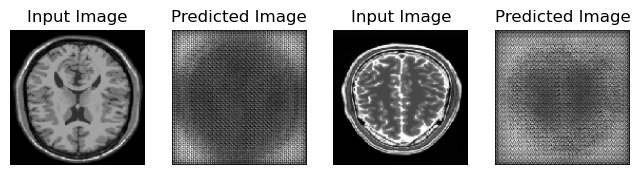

Saving checkpoint for epoch 1 at ./Trained_Model\ckpt-1


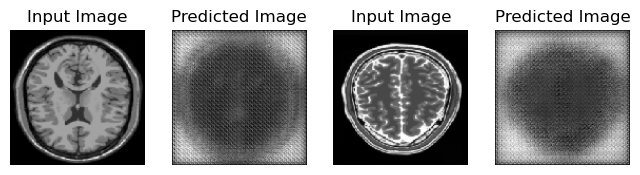

Saving checkpoint for epoch 2 at ./Trained_Model\ckpt-2


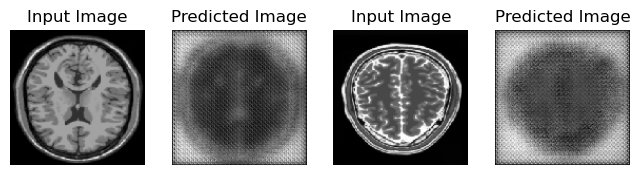

Saving checkpoint for epoch 3 at ./Trained_Model\ckpt-3


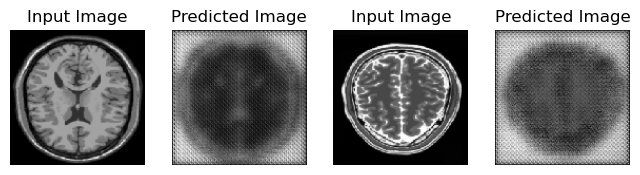

Saving checkpoint for epoch 4 at ./Trained_Model\ckpt-4


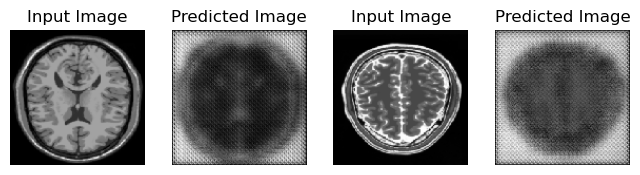

Saving checkpoint for epoch 5 at ./Trained_Model\ckpt-5


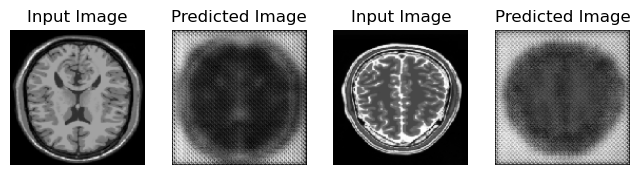

Saving checkpoint for epoch 6 at ./Trained_Model\ckpt-6


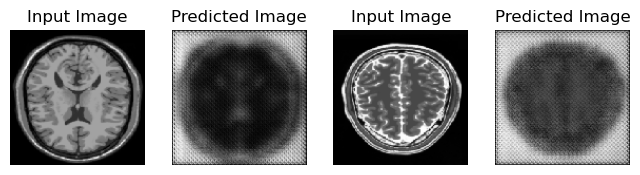

Saving checkpoint for epoch 7 at ./Trained_Model\ckpt-7


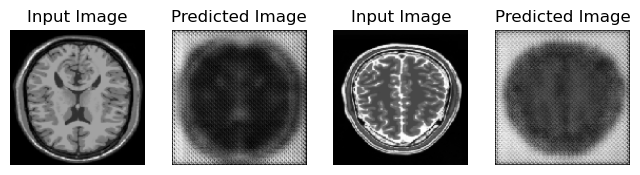

Saving checkpoint for epoch 8 at ./Trained_Model\ckpt-8


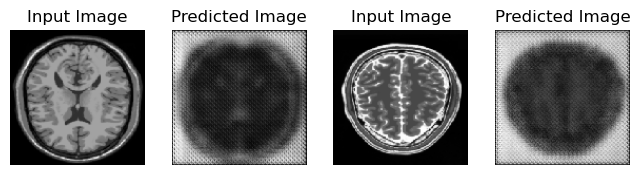

Saving checkpoint for epoch 9 at ./Trained_Model\ckpt-9


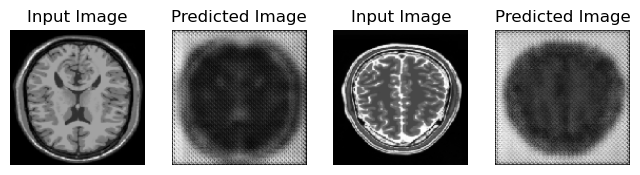

Saving checkpoint for epoch 10 at ./Trained_Model\ckpt-10


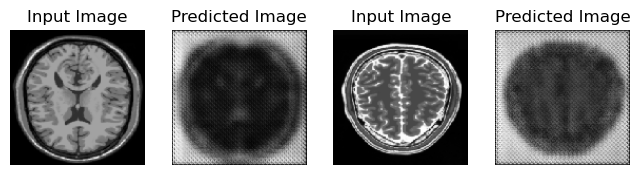

Saving checkpoint for epoch 11 at ./Trained_Model\ckpt-11


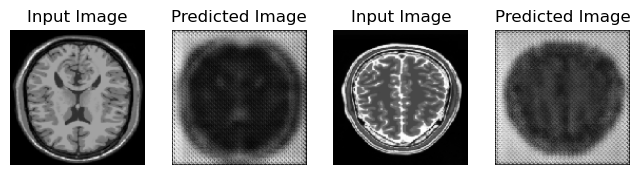

Saving checkpoint for epoch 12 at ./Trained_Model\ckpt-12


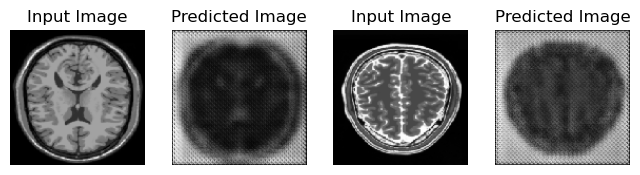

Saving checkpoint for epoch 13 at ./Trained_Model\ckpt-13


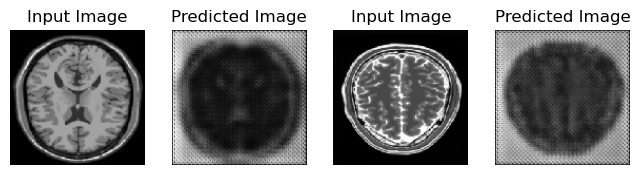

Saving checkpoint for epoch 14 at ./Trained_Model\ckpt-14


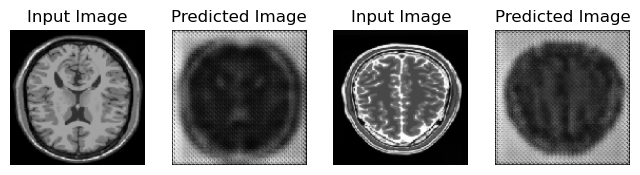

Saving checkpoint for epoch 15 at ./Trained_Model\ckpt-15


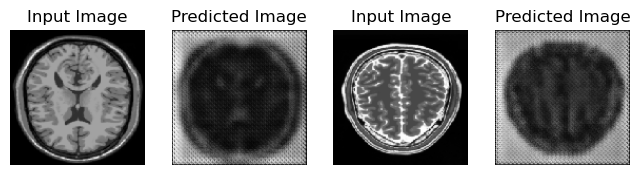

Saving checkpoint for epoch 16 at ./Trained_Model\ckpt-16


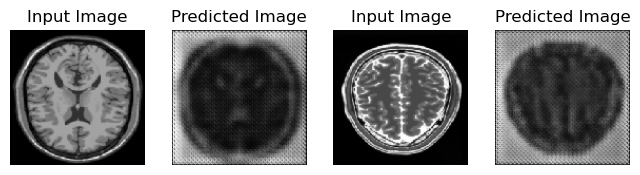

Saving checkpoint for epoch 17 at ./Trained_Model\ckpt-17


KeyboardInterrupt: 

In [61]:
for epoch in range(1,Epochs+1):
    for image_x,image_y in tf.data.Dataset.zip((data_T1, data_T2)):
        train_start(image_x, image_y)
    generate_images(generator_g, example_T1, generator_f, example_T2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)